In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
col_names = ['cycle', 'op', 'width', 'addr']

### Load trace

In [3]:
df = pd.read_csv('../traces/fft.csv', names=col_names)

### Setup Blocks

In [4]:
block_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512] # number of 32bit words
for bs in block_sizes:
    shift_val = int(np.log2(bs*4)) 
    df[f'block_{bs}'] = np.right_shift(df.addr & 0xffffffff, shift_val)

In [5]:
hibernus_word = len(df.block_1.unique())
hibernus_page_512 = len(df.block_128.unique())*128
hibernus_page_1K = len(df.block_256.unique())*256 
hibernus_page_2K = len(df.block_512.unique())*512

## Power failures following a Poisson distribution

The execution time of the program can be approximated with the clock cycle count of the last memory operation

In [6]:
df.cycle.iloc[-1]

61784594

The event of a power faiulure can be modelled also as a binomial.
In every cycle there is a probability for the event to happen, as the probability is small and the number of cycles is very large this is well approximated by a Poisson.

##### Here we suppose that
- Each power failure is independent from the previous ones.
- The average failure rate is one every 10M clock cycles.

With these assumpions the process can be modelled with a Poisson distribution.

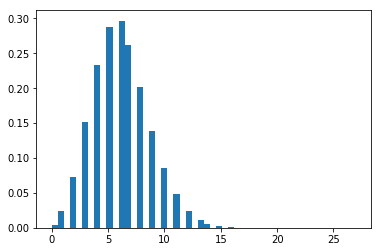

In [7]:
pwr_fail_per_cycle = 1e-7
prog_cycles = df.cycle.iloc[-1]
lam = pwr_fail_per_cycle * prog_cycles
s = np.random.poisson(lam, prog_cycles)
count, bins, ignored = plt.hist(s, 50, density=True)

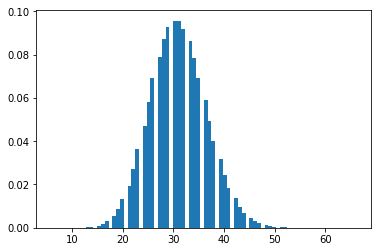

In [8]:
lam2 = 5e-7 * prog_cycles
t = np.random.poisson(lam2, prog_cycles)
count, bins, ignored = plt.hist(t, 80, density=True)

$5e-7$ Power fail per cycle

Given:
- probability of power failure p = 1 fail / 10 Mcycles

To simulate the execution with power failures, generate a list as long as the number of clock cycles, where every element can be 0 or 1 with probabilities 1-p and p.

In [9]:
np.random.binomial(prog_cycles, pwr_fail_per_cycle)

7

In [10]:
events = np.random.choice([0, 1], size = prog_cycles, replace=True, p=[1-pwr_fail_per_cycle, pwr_fail_per_cycle])
pwr_fail_times = np.where(events==1)[0]
pwr_fail_times

array([ 8160665,  8755513, 19307768, 27199475, 55174152])

The waiting time between two consecutive pwr failures is the size of the interval

In [11]:
waiting_times = np.diff(pwr_fail_times)
waiting_times

array([  594848, 10552255,  7891707, 27974677])

## Divide trace in intervals based on the power failure times

In [12]:
df['interval'] = 0
for t in pwr_fail_times:
    df['interval'] += t < df.cycle

In [13]:
df.interval.value_counts()

4    4295534
5    1059954
2     905906
0     708592
3     672850
1      51312
Name: interval, dtype: int64

### Number of address accessed per interval

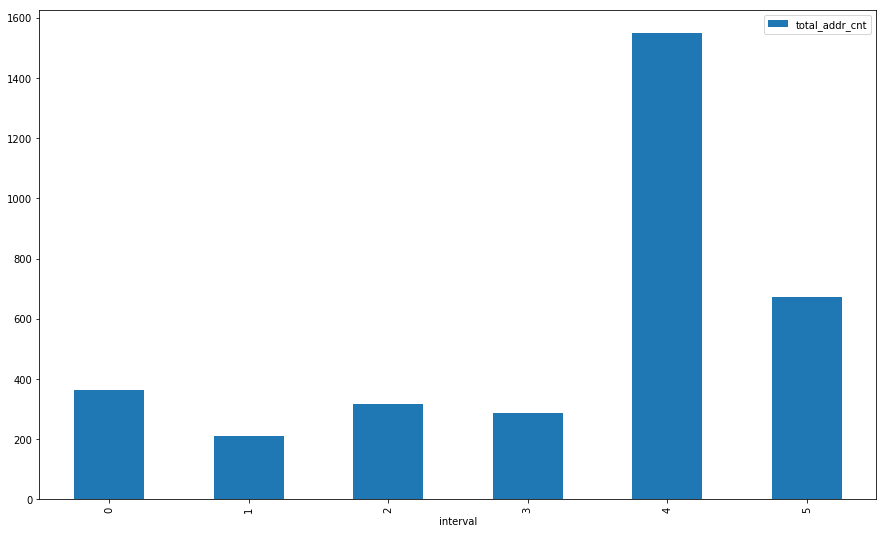

In [14]:
addr_cnt_per_interval = df[['interval', 'block_1']].drop_duplicates().groupby('interval').size()
addr_cnt_per_interval.to_frame('total_addr_cnt').plot(kind='bar', figsize=(15,9))
plt.show()

### Number of modified blocks per interval

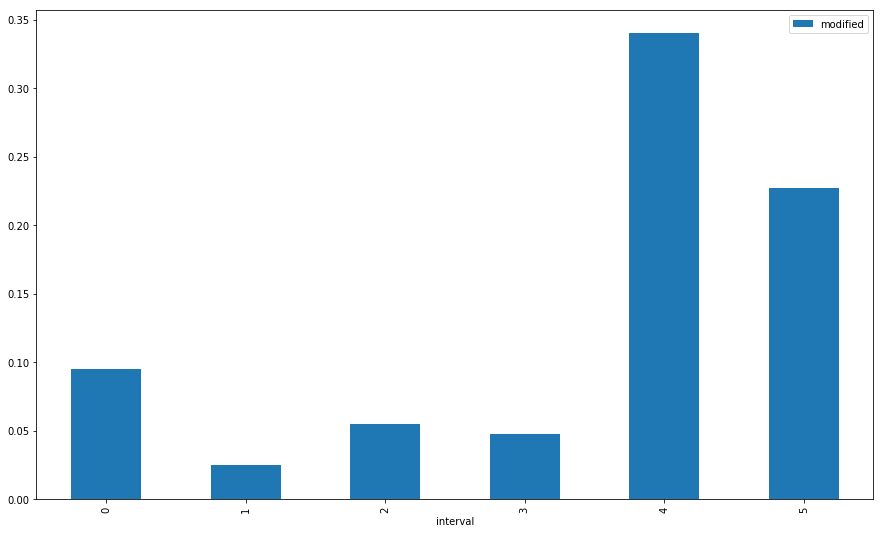

In [15]:
by_interval = df[['block_8', 'op', 'interval']].groupby('interval')
modified_in_interval = by_interval.apply(lambda g: g[(g.op == 'ST')].block_8.nunique()) * 8
(modified_in_interval / hibernus_page_512).to_frame('modified').plot(kind='bar', figsize=(15,9))
plt.show()

## Average savings

In [16]:
(1 - modified_in_interval / hibernus_page_512).mean()

0.8683333333333333

# Multi-trace analysis

### Load dataframe

Dataframe contains average results for 100 executions with $1e-7$ average failure rate

In [17]:
comp_df = pd.read_csv('../res/random_intervals/poisson_1e-7_iv_100-executions.csv', index_col='trace')
comp_df

full_mem_page512  savings_avg  savings_std  \
trace                                                                
susan_smooth_small.csv            7040.0     0.723845     0.138004   
susan_edge_small.csv             13696.0     0.302723     0.200106   
crc_large.csv                     2048.0     0.777344     0.000000   
matmul_float_16.csv               2944.0     0.803878     0.030105   
fft.csv                           3200.0     0.830580     0.048433   
cjpeg.nocache.csv                10624.0     0.382722     0.139052   
search_large.csv                  8960.0     0.705472     0.108841   
qsort_small.csv                 322688.0     0.565239     0.166226   
matmul_int_16.csv                 2560.0     0.779266     0.017018   
dijkstra.csv                     14848.0     0.737637     0.076200   
matmul_int_32.csv                 4864.0     0.753476     0.054946   
susan_edge_large.csv            168704.0     0.892310     0.026569   
average                          46848.0     0.687874     0.083792   

                        num_interval_avg  num_interval_std  
trace                                                       
susan_smooth_small.csv            4.3500          1.849788  
susan_edge_small.csv              1.5100          0.703455  
crc_large.csv                     1.0000          0.000000  
matmul_float_16.csv               4.2900          1.892543  
fft.csv                           6.9800          2.498404  
cjpeg.nocache.csv                 1.6000          0.804030  
search_large.csv                  2.0100          0.881860  
qsort_small.csv                   4.2200          1.823417  
matmul_int_16.csv                 1.0600          0.238683  
dijkstra.csv                      8.4500          2.793842  
matmul_int_32.csv                 1.3800          0.599326  
susan_edge_large.csv             15.0200          3.722658  
average                           4.3225          1.484000

### Renaming with abbreviations

In [18]:
abbreviations = ['sss', 'ses', 'crc', 'mm16f', 'fft', 'cjpeg', 'sl', 'qsort', 'mm16i', 'dijk', 'mm32i', 'sel', 'avg']
name_map = dict(zip(comp_df.index, abbreviations))

In [19]:
comp_df['trace'] = comp_df.index.map(name_map)
comp_df = comp_df.reset_index(drop=True).set_index('trace')
comp_df

full_mem_page512  savings_avg  savings_std  num_interval_avg  \
trace                                                                 
sss              7040.0     0.723845     0.138004            4.3500   
ses             13696.0     0.302723     0.200106            1.5100   
crc              2048.0     0.777344     0.000000            1.0000   
mm16f            2944.0     0.803878     0.030105            4.2900   
fft              3200.0     0.830580     0.048433            6.9800   
cjpeg           10624.0     0.382722     0.139052            1.6000   
sl               8960.0     0.705472     0.108841            2.0100   
qsort          322688.0     0.565239     0.166226            4.2200   
mm16i            2560.0     0.779266     0.017018            1.0600   
dijk            14848.0     0.737637     0.076200            8.4500   
mm32i            4864.0     0.753476     0.054946            1.3800   
sel            168704.0     0.892310     0.026569           15.0200   
avg             46848.0     0.687874     0.083792            4.3225   

       num_interval_std  
trace                    
sss            1.849788  
ses            0.703455  
crc            0.000000  
mm16f          1.892543  
fft            2.498404  
cjpeg          0.804030  
sl             0.881860  
qsort          1.823417  
mm16i          0.238683  
dijk           2.793842  
mm32i          0.599326  
sel            3.722658  
avg            1.484000

### Filter benchmarks with 2 or more power failure

In [20]:
subset = comp_df[comp_df.num_interval_avg>1.8].iloc[:-1]
subset.loc['avg'] = subset.mean()
subset

full_mem_page512  savings_avg  savings_std  num_interval_avg  \
trace                                                                 
sss         7040.000000     0.723845     0.138004          4.350000   
mm16f       2944.000000     0.803878     0.030105          4.290000   
fft         3200.000000     0.830580     0.048433          6.980000   
sl          8960.000000     0.705472     0.108841          2.010000   
qsort     322688.000000     0.565239     0.166226          4.220000   
dijk       14848.000000     0.737637     0.076200          8.450000   
sel       168704.000000     0.892310     0.026569         15.020000   
avg        75483.428571     0.751280     0.084911          6.474286   

       num_interval_std  
trace                    
sss            1.849788  
mm16f          1.892543  
fft            2.498404  
sl             0.881860  
qsort          1.823417  
dijk           2.793842  
sel            3.722658  
avg            2.208930

### Average Savings

(0.35, 1)

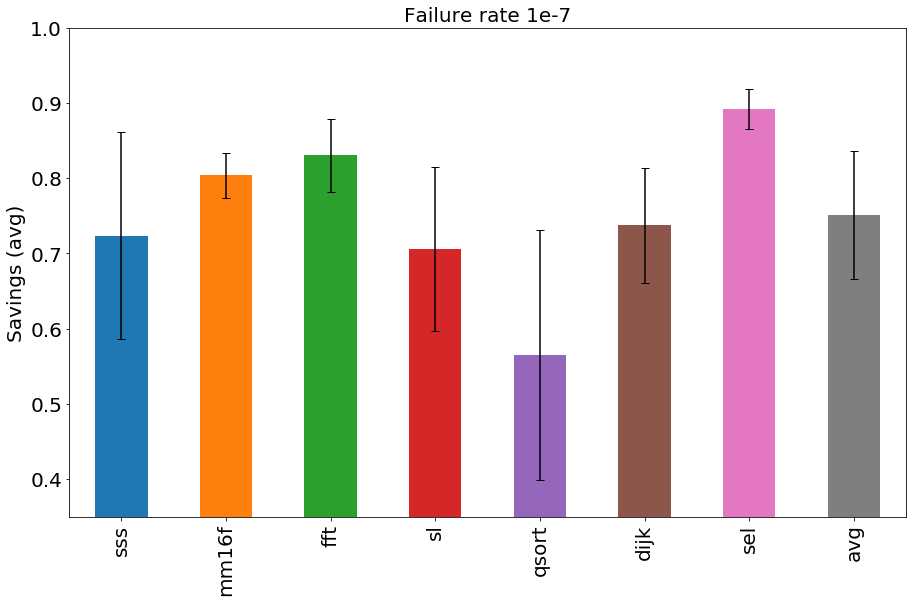

In [21]:
ax = subset.savings_avg.plot.bar(yerr=subset.savings_std, capsize=4, figsize=(15,9), fontsize=20)
ax.set_title('Failure rate 1e-7', fontsize=20)
ax.set_ylabel('Savings (avg)', fontsize=20)
ax.set_xlabel('')
ax.set_ylim([.35, 1])

In [22]:
subset

full_mem_page512  savings_avg  savings_std  num_interval_avg  \
trace                                                                 
sss         7040.000000     0.723845     0.138004          4.350000   
mm16f       2944.000000     0.803878     0.030105          4.290000   
fft         3200.000000     0.830580     0.048433          6.980000   
sl          8960.000000     0.705472     0.108841          2.010000   
qsort     322688.000000     0.565239     0.166226          4.220000   
dijk       14848.000000     0.737637     0.076200          8.450000   
sel       168704.000000     0.892310     0.026569         15.020000   
avg        75483.428571     0.751280     0.084911          6.474286   

       num_interval_std  
trace                    
sss            1.849788  
mm16f          1.892543  
fft            2.498404  
sl             0.881860  
qsort          1.823417  
dijk           2.793842  
sel            3.722658  
avg            2.208930

# Higher failure rate (1e-6) 

In [23]:
comp_df = pd.read_csv('../res/random_intervals/poisson_1e-6_iv_100.csv', index_col='trace')
comp_df['trace'] = comp_df.index.map(name_map)
comp_df = comp_df.reset_index(drop=True).set_index('trace')
comp_df

full_mem_page512  savings_avg  savings_std  num_interval_avg  \
trace                                                                 
sss              7040.0     0.966452     0.005600           34.1100   
ses             13696.0     0.794762     0.102831            6.2100   
crc              2048.0     0.778789     0.010183            1.0200   
mm16f            2944.0     0.859050     0.005370           33.6600   
fft              3200.0     0.913177     0.006442           62.4300   
cjpeg           10624.0     0.738998     0.055466            8.0900   
sl               8960.0     0.910767     0.013257           11.3000   
qsort          322688.0     0.909668     0.015859           32.4800   
mm16i            2560.0     0.823307     0.044248            1.8300   
dijk            14848.0     0.894611     0.007329           76.5700   
mm32i            4864.0     0.887597     0.036801            5.1300   
sel            168704.0     0.987458     0.000867          141.4400   
avg             46848.0     0.872053     0.025355           34.5225   

       num_interval_std  
trace                    
sss            6.078435  
ses            2.244162  
crc            0.140705  
mm16f          6.348817  
fft            8.439033  
cjpeg          2.881831  
sl             3.346942  
qsort          5.975506  
mm16i          0.865209  
dijk           9.446559  
mm32i          2.023374  
sel           10.043662  
avg            4.819519

#### Filter benchmarks with more than 1 power failure

In [24]:
subset = comp_df[comp_df.num_interval_avg>1.5].iloc[:-1]
subset.loc['average'] = subset.mean()
subset

full_mem_page512  savings_avg  savings_std  num_interval_avg  \
trace                                                                   
sss           7040.000000     0.966452     0.005600         34.110000   
ses          13696.000000     0.794762     0.102831          6.210000   
mm16f         2944.000000     0.859050     0.005370         33.660000   
fft           3200.000000     0.913177     0.006442         62.430000   
cjpeg        10624.000000     0.738998     0.055466          8.090000   
sl            8960.000000     0.910767     0.013257         11.300000   
qsort       322688.000000     0.909668     0.015859         32.480000   
mm16i         2560.000000     0.823307     0.044248          1.830000   
dijk         14848.000000     0.894611     0.007329         76.570000   
mm32i         4864.000000     0.887597     0.036801          5.130000   
sel         168704.000000     0.987458     0.000867        141.440000   
average      50920.727273     0.880532     0.026734         37.568182   

         num_interval_std  
trace                      
sss              6.078435  
ses              2.244162  
mm16f            6.348817  
fft              8.439033  
cjpeg            2.881831  
sl               3.346942  
qsort            5.975506  
mm16i            0.865209  
dijk             9.446559  
mm32i            2.023374  
sel             10.043662  
average          5.244866

(0.65, 1)

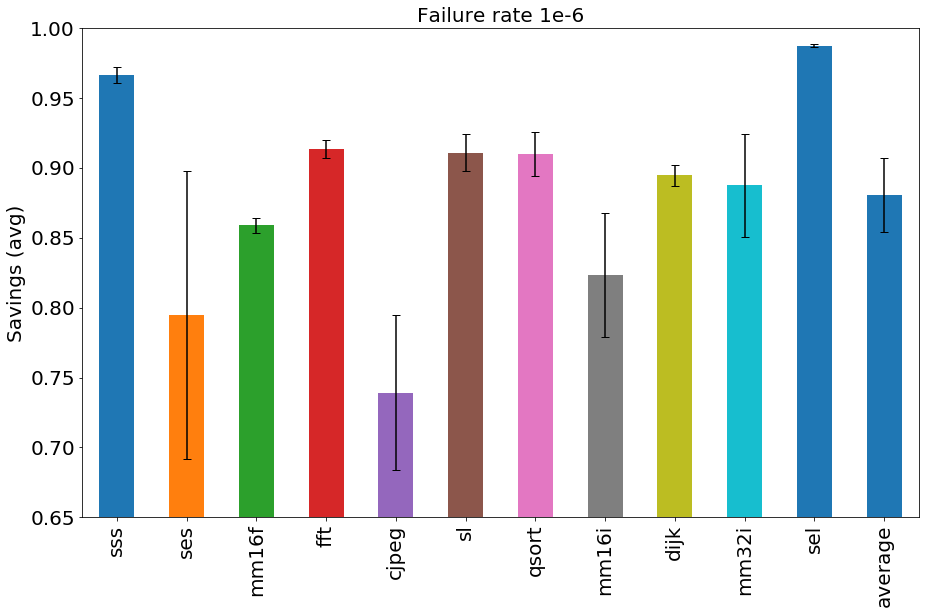

In [25]:
ax = subset.savings_avg.plot.bar(yerr=subset.savings_std, capsize=4, figsize=(15,9), fontsize=20)
ax.set_title('Failure rate 1e-6', fontsize=20)
ax.set_ylabel('Savings (avg)', fontsize=20)
ax.set_xlabel('')
ax.set_ylim([.65, 1])